# ML Immobilier - Californie


## Identify the problem and research a global vision

- **Objectif:** Predicting median home prices in California districts
- **Problem:** Supervised learning - Regression - Offline
- **Metrics:** RMSE

**Fondamental Analysis**

...

**Form analysis**
- *Identify the target:* median_house_value
- *Number of the rows and columns:* 20640, 10 (It's relatively small for a ML game!)
- *Type of variables:* 1 categorical, 9 numerics
- *Identify missing values:* No missing values(NaN) except the variable *total_bedrooms* which contains 207/20640 missing values (1%)

**Content analysis**
- *Visualize the target:* median_house_value is normalized (<=500000$) --> *Getting the correct labels for homes whose values have been capped at 500000$ OR Remove them!*
- *Understand the different variables:*
    - median_income is normalized [0. 5 - 15] with (1 = 10000$/year)
    - housing_median_age is normalized [1 - 52] with (...?)
    - The variables have very different scales --> *Think about normalizing the variables!*
    - Many histograms are very skewed; they extend more to the right than to the left --> *Think about transforming the variables to obtain a more symmetrical distribution!*
- *Visualize features-target relationships:* The most promising variable for prediction median_house_value is median_income
    - The 500000$ ceiling is visible in the graph
    - There are also other lines around 450000, 350000, 280000, etc --> *Think about removing these districts!*
- *Identify outliers:*


## Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint

from scipy import stats

# Chercher à quoi ça sert !!!
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel


## Get Data

In [133]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
            
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [45]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# I. Preliminary data analysis 

## Form analysis

In [55]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [58]:
housing.dtypes.value_counts()

float64    9
object     1
Name: count, dtype: int64

In [57]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [62]:
housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

<Axes: >

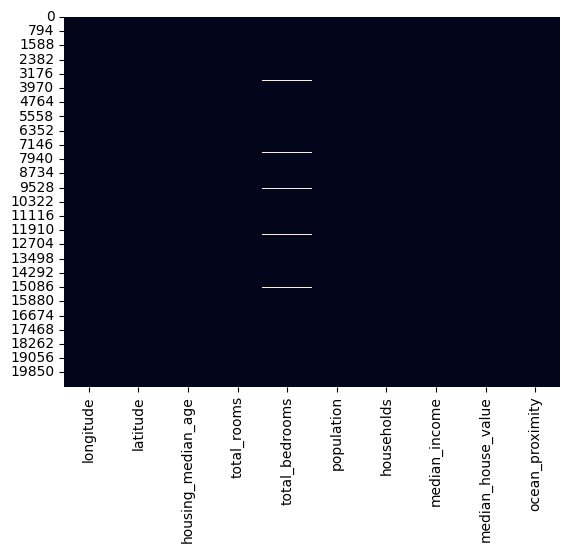

In [60]:
sns.heatmap(housing.isna(), cbar=False)

## Content analysis

### Numeric variables

In [22]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


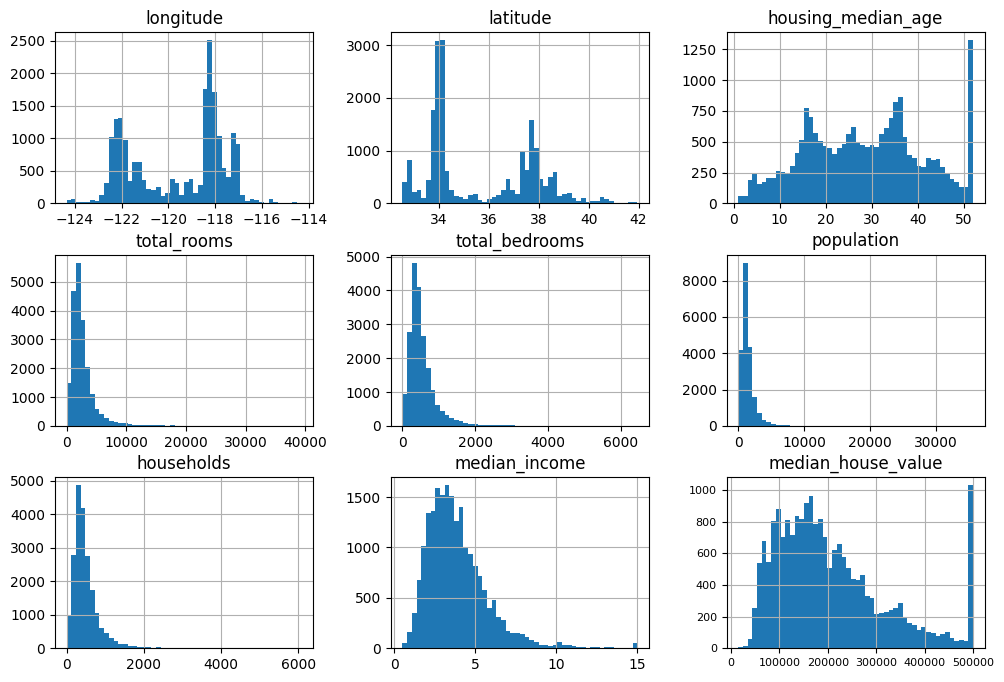

In [75]:
housing.hist(bins=50, figsize=(12, 8))
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

### Categorical variables

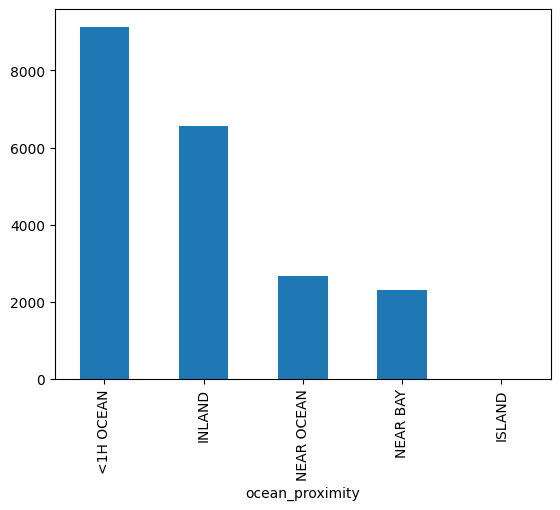

In [79]:
housing['ocean_proximity'].value_counts().plot(kind="bar")
plt.show()

## Create a train_set and test_set

In [134]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

print(f"train_set: {train_set.shape}")
print(f"test_set: {test_set.shape}")

train_set: (16512, 10)
test_set: (4128, 10)


Is the test_set representative of the different income brackets *median_income*?

# II. Exploratory Data Analysis - EDA

In [162]:
housing = train_set.copy()

### Visualizing Geographical Data

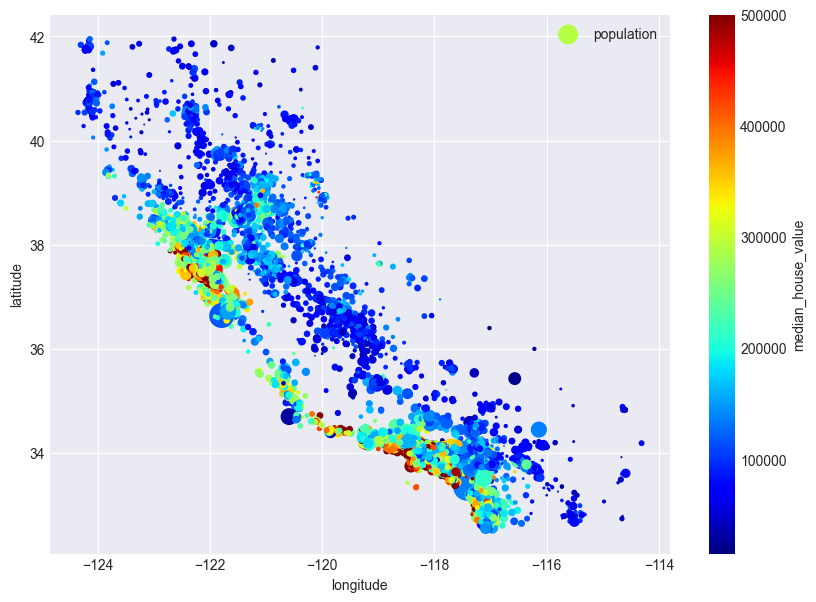

In [137]:
housing.plot(kind='scatter', x='longitude', y='latitude', grid=True,
              s=housing['population']/100, label='population',
              c='median_house_value', cmap='jet', colorbar=True,
              sharex=False, figsize=(10, 7))
plt.show()

### Looking for correlations

In [122]:
# Heat map
def get_corr_matrix_and_heatmap(df):

    # Calculate correlation
    corr_matrix = df.corr(numeric_only=True)

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Set up the matplotlib figure
    plt.style.use('seaborn-v0_8-darkgrid')
    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot the correlation matrix
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5, square=True, ax=ax)
    return corr_matrix, fig


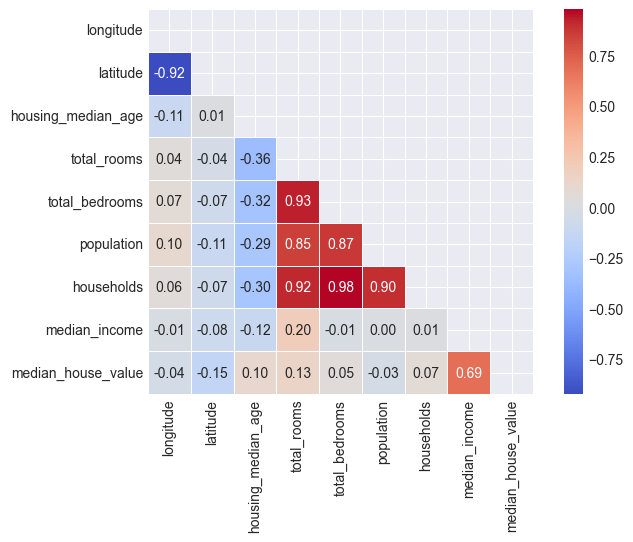

In [123]:
corr_matrix, heatmap = get_corr_matrix_and_heatmap(housing)

In [138]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687013
total_rooms           0.134060
housing_median_age    0.104714
households            0.065798
total_bedrooms        0.049993
population           -0.025820
longitude            -0.043603
latitude             -0.146324
Name: median_house_value, dtype: float64

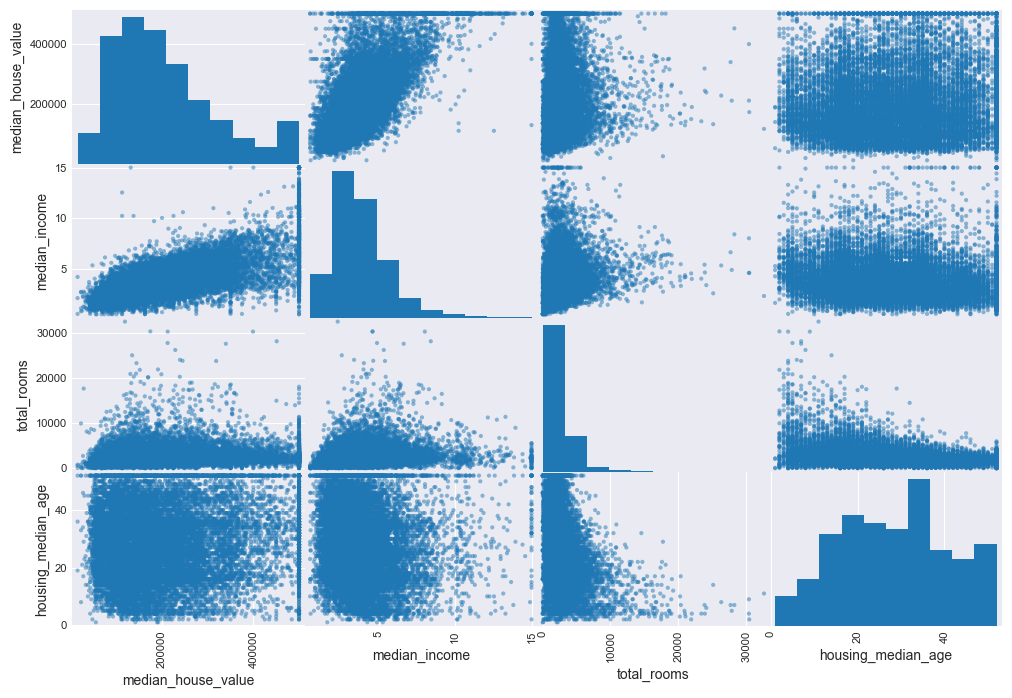

In [140]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

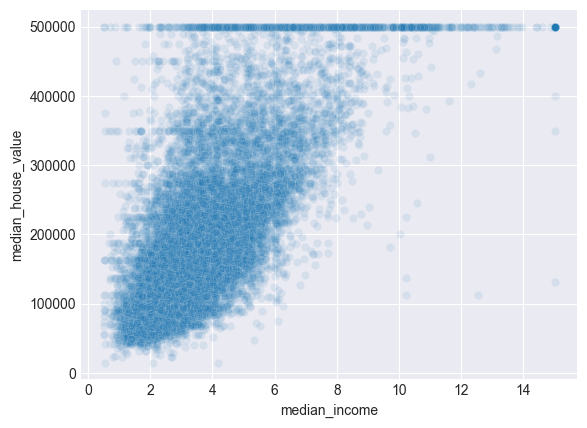

In [150]:
sns.scatterplot(data=housing, x="median_income", y="median_house_value", alpha=0.1)
plt.show()

### Experimenting with attribute combinations

In [151]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["poeple_per_house"] = housing["population"] / housing["households"]

In [154]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687013
rooms_per_house       0.146940
total_rooms           0.134060
housing_median_age    0.104714
households            0.065798
total_bedrooms        0.049993
poeple_per_house     -0.021577
population           -0.025820
longitude            -0.043603
latitude             -0.146324
bedrooms_ratio       -0.254817
Name: median_house_value, dtype: float64

# III. Pre-Processing

In [163]:
housing = train_set.drop("median_house_value", axis=1)
housing_labels = train_set["median_house_value"]

## Data Cleaning

In [169]:
housing_numeric = housing.select_dtypes(include=[np.number])

In [170]:
imputer = SimpleImputer(strategy="median")
imputer.fit(housing_numeric)

SimpleImputer(strategy='median')

In [172]:
X = imputer.transform(housing_numeric)

In [191]:
housing_num_tr = pd.DataFrame(X, columns=housing_numeric.columns, index=housing_numeric.index)
housing_num_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
14196,-117.22,32.75,34.0,6001.0,1111.0,2654.0,1072.0,4.5878
8267,-117.03,32.69,10.0,901.0,163.0,698.0,167.0,4.6648
17445,-122.27,37.74,28.0,6909.0,1554.0,2974.0,1484.0,3.6875
14265,-121.82,37.25,25.0,4021.0,634.0,2178.0,650.0,5.1663
2271,-115.98,33.32,8.0,240.0,46.0,63.0,24.0,1.4688


## Encoding

In [180]:
housing_cat = housing[['ocean_proximity']]

In [183]:
cat_encoder = OneHotEncoder(drop="first", sparse_output=False)
housing_cat_encoded = cat_encoder.fit_transform(housing_cat)

In [184]:
housing_cat_encoded[:8]

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [190]:
housing_cat_tr = pd.DataFrame(housing_cat_encoded, columns=cat_encoder.get_feature_names_out(), index=housing_cat.index)
housing_cat_tr.head()

,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
14196,0.0,0.0,0.0,1.0
8267,0.0,0.0,0.0,1.0
17445,0.0,0.0,1.0,0.0
14265,0.0,0.0,0.0,0.0
2271,1.0,0.0,0.0,0.0


## Feature scaling

**Normalisation**

In [200]:
minmax_scaler =  MinMaxScaler(feature_range=(-1, 1))
housing_num_minmax_scaled = minmax_scaler.fit_transform(housing_numeric)

**Standarisation**

In [194]:
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_numeric)

**Log transformation**

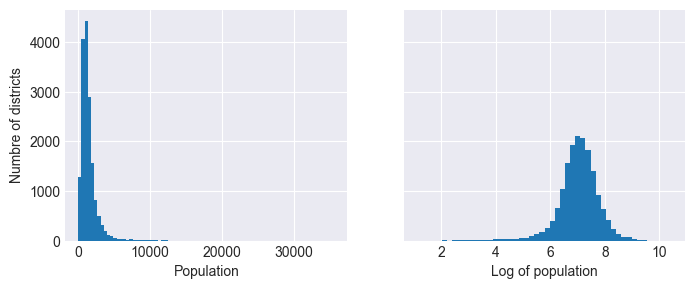

In [220]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(bins=80, ax=ax[0])
housing["population"].apply(np.log).hist(bins=50, ax=ax[1])
ax[0].set_xlabel("Population")
ax[0].set_ylabel("Numbre of districts")
ax[1].set_xlabel("Log of population")
plt.show()

**Transformer les variables *latitude* et *longitude***

In [318]:
class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, n_init=10,
                              random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self  # always return self!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

**Custom Transformers**

In [224]:
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_population = log_transformer.transform(housing["population"])

## Pipeline

In [319]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

cat_pipeline =  make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(sparse_output=False, handle_unknown="ignore", drop="first"))

default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house",ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)), # type: ignore
],
remainder=default_num_pipeline)
preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                             SimpleImputer(strategy='median')),
                                            ('standardscaler',
                                             StandardScaler())]),
                  transformers=[('bedrooms',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('functiontransformer',
                                                  FunctionTransformer(feature_names_out=<function ratio_name at 0x1323593a0>,
                                                                      func=<function column_ratio at 0...
                                  'households', 'median_income']),
                                ('geo', ClusterSimilarity(random_state=42),
                                 ['latitude', 'longitude']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x13dd4ecf0>)])

In [320]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 23)

# IV. Modeling

In [322]:
# Model 1 : LinearRegression
lin_reg = make_pipeline(preprocessing, LinearRegression())

In [ ]:
# Model 2 : DecisionTreeRegressor
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))

In [ ]:
# Model 3 : RandomForestRegressor
forest_reg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))

In [289]:
housing_predictions_lin = lin_reg.predict(housing)

In [299]:
housing_predictions_tree = tree_reg.predict(housing)

# V. Evaluation

In [ ]:
# Evaluation model 1 : LinearRegression
lin_rmse = -cross_val_score(lin_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.DataFrame(lin_rmse).describe()

,0
count,10.000000
mean,70591.118111
std,5477.834398
min,66530.236569
25%,68137.811232
50%,69160.196337
75%,70346.882271
max,85432.466775


In [ ]:
# Evaluation model 2 : DecisionTreeRegression
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions_tree)
tree_rmse

0.0

In [325]:
tree_rmses = -cross_val_score(tree_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(tree_rmses).describe()

count       10.000000
mean     69723.262485
std       1497.974605
min      66823.891577
25%      69193.686553
50%      69511.779795
75%      70544.356601
max      72447.982209
dtype: float64

In [324]:
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(forest_rmses).describe()

count       10.000000
mean     49531.068742
std        851.047938
min      48371.914556
25%      48945.411146
50%      49558.254898
75%      49983.620993
max      51256.556537
dtype: float64

In [326]:
forest_reg.fit(housing, housing_labels)
forest_pred = forest_reg.predict(housing)
root_mean_squared_error(housing_labels, forest_pred)

18480.77361366261

**Model 3 "*RandomForestRegressor*" is the best-performing of the three models, but it is overfitting because the error on the training dataset is much smaller than the error on the validation dataset.**

# VI. Fine-Tune Model

## Grid Search

- Les combinaisons à tester et nbr d'entrainement:
    - 3 x 3 = 9  et 2 x 3 = 6 => **15 combinaisons**
    - cv = 3 => 3 x 15 => **45 entrainements** 

In [327]:
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])

param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]

grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring="neg_root_mean_squared_error")
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x13dd4ecf0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

**La meilleure Combinaison**

In [ ]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

**Le meilleur Model**

In [330]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x1323593...
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x13d582690>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=6, random_state=42))])

**Visualiser les resultats de GridSearchCV**

In [341]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,43086,43803,43785,43558
13,15,8,43517,43955,43946,43806
6,10,4,43903,44429,44468,44267
7,10,6,44183,44939,44720,44614
9,10,6,44183,44939,44720,44614


## Randomized Search

In [344]:
param_distribs = {'preprocessing__geo__n_clusters': randint(low=3, high=50),
                  'random_forest__max_features': randint(low=2, high=20)}

rnd_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42)

rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x13dd4ecf0>)])),
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13da9cec0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13e056390>},
                   random_state=42, scoring='neg_root_mean_squared_error')

**La meilleure combinaison** 

In [346]:
rnd_search.best_params_

{'preprocessing__geo__n_clusters': 45, 'random_forest__max_features': 9}

**Le meilleur Model**

In [345]:
rnd_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x1323593...
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x13e396120>)])),
                ('random_forest',
                 RandomForestRegressor(max_features=9, random_state=42))])

**Visualiser les resultats de RandomizedSearchCV**

In [347]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)
cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
1,45,9,41497,42260,42672,42143
8,32,7,41622,42550,42602,42258
5,42,4,41875,42496,43318,42563
6,24,3,42116,43306,43450,42957
2,23,8,42467,43105,43389,42987


## Analyze the Best Models and Thier Errors

In [348]:
final_model = rnd_search.best_estimator_

In [371]:
feature_importances = final_model["random_forest"].feature_importances_ # type: ignore
sorted(zip(feature_importances, final_model["preprocessing"].get_feature_names_out()), reverse=True)[:10] # type: ignore

[(np.float64(0.1960242929858818), 'log__median_income'),
 (np.float64(0.08076586875263718), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.06862341730620208), 'bedrooms__ratio'),
 (np.float64(0.04665369497155537), 'rooms_per_house__ratio'),
 (np.float64(0.04364572682557229), 'people_per_house__ratio'),
 (np.float64(0.03620575859085285), 'geo__Cluster 32 similarity'),
 (np.float64(0.02752818275801899), 'geo__Cluster 29 similarity'),
 (np.float64(0.022597062097797566), 'geo__Cluster 11 similarity'),
 (np.float64(0.018037691821348362), 'geo__Cluster 7 similarity'),
 (np.float64(0.017622530483386332), 'geo__Cluster 17 similarity')]

## Evaluate the Final Model on the test set

In [374]:
X_test = test_set.drop("median_house_value", axis=1)
y_test = test_set["median_house_value"]

final_predictions = final_model.predict(X_test) # type: ignore

final_rmse = root_mean_squared_error(y_test, final_predictions)
final_rmse

42365.045396202266

## Confidence interval (95%) for the RMSE

In [ ]:
def rmse(squared_errors):
    return np.sqrt(np.mean(squared_errors))

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
boot_result = stats.bootstrap([squared_errors], rmse, confidence_level=confidence, random_state=42) # type: ignore
rmse_lower, rmse_upper = boot_result.confidence_interval

In [ ]:
(rmse_lower, rmse_upper)

(np.float64(40237.170682803844), np.float64(44772.76736485899))

# VII. Model Deployment, Monitoring, and Maintenance